# Bayesian Linear Regression
$$
\mathbf{y} \sim \mathcal{N} \left(\beta^T \mathbf{X}, \sigma^2 \mathbf{I} \right)
$$
Response datapoints $y$ are sampled from a multivariate normal distribution that has a mean equal to the product of the $\beta$ coefficients and the predictors, $X$, and a variance of $\sigma^2$. Here, $I$ refers to the identity matrix, which is necessary because the distribution is multivariate.

In [71]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Need scipy because dataset is in matlab format
import scipy.stats
import scipy.io
from theano import shared
from sklearn.model_selection import train_test_split

## Load Dataset

In [72]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [73]:
datx = olympics[:,0]
daty = olympics[:,1]

In [74]:
X_train, X_test, y, y_test = train_test_split(
            datx, daty, test_size=0.33)
x = shared(X_train)


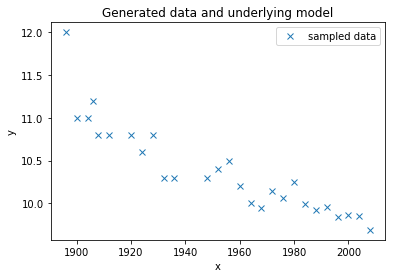

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(datx, daty, 'x', label='sampled data')
plt.legend(loc=0);

Note that we have not normalized the data and this should have a slight impact on the performance of the sampler. This is purely for convenience.

In [76]:
with pm.Model() as model:
    sigma = pm.distributions.Beta('sigma', 1, 2)
    intercept = pm.distributions.Normal('Intercept', 0, sd=20)
    x_coeff = pm.distributions.Normal('x', 0, sd=20)


    likelihood = pm.distributions.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)
    
    start = pm.find_MAP()

    # Use the No-U-Turn Sampler
    step = pm.NUTS()

    # Calculate the trace
    trace = pm.sample(
        500, step, start, 
        random_seed=42, progressbar=True, njobs=1, chains=2
        )

logp = -29.053, ||grad|| = 0.49006: 100%|██████████| 34/34 [00:00<00:00, 2526.47it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma_logodds__]
100%|██████████| 1000/1000 [00:38<00:00, 26.03it/s]
The acceptance probability does not match the target. It is 0.904268207806, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895307169189, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


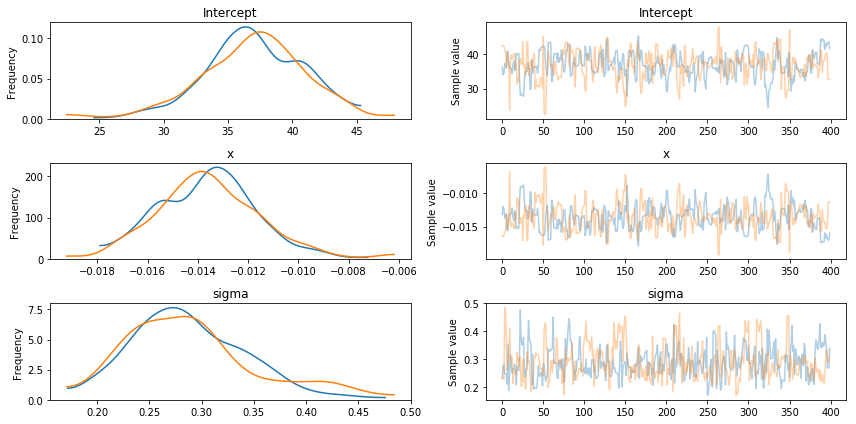

In [77]:
pm.traceplot(trace[100:])
plt.tight_layout();

In [78]:
print(pm.summary(trace[-1000:]))  

                mean        sd  mc_error    hpd_2.5   hpd_97.5  n_eff  \
Intercept  37.044292  4.027203  0.261683  29.226873  44.777705  177.0   
x          -0.013652  0.002070  0.000134  -0.017397  -0.009435  177.0   
sigma       0.290651  0.058869  0.003246   0.195033   0.421188  295.0   

               Rhat  
Intercept  1.001984  
x          1.001996  
sigma      0.999000  


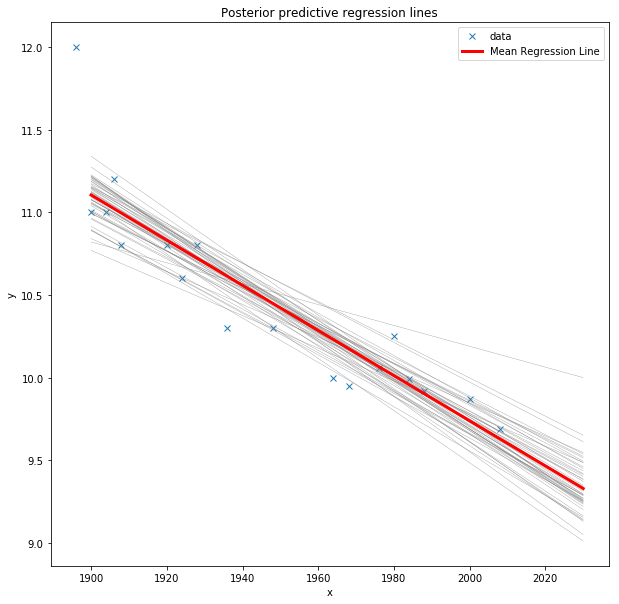

In [79]:
plt.figure(figsize=(10, 10))
lm = lambda x, sample: sample['Intercept'] + sample['x'] * x
eval = np.linspace(1900, 2030, 100)


plt.plot(X_train, y, 'x', label='data')
for rand_loc in np.random.randint(0, len(trace), 50):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), color="grey", lw=0.3)
   
intercepts = trace["Intercept"][:, None] 
intercept = np.mean(intercepts); 

ws = trace["x"][:, None]
w = np.mean(ws);
bx = np.linspace(1900, 2030, 50)
by = intercept + w*bx 
plt.plot(bx, by, label="Mean Regression Line", lw=3., c="red")

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');


In [80]:
x.set_value(X_test)
ppc = pm.sample_ppc(trace, model=model, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3446.32it/s]


In [81]:
mean = np.mean(ppc['y'], 0)
maxe = np.max(ppc['y'], 0) - mean
mine = mean - np.min(ppc['y'], 0) 

In [82]:
errors = np.stack((mine, maxe), 0)

In [83]:
ppc['y'].shape

(1000, 9)

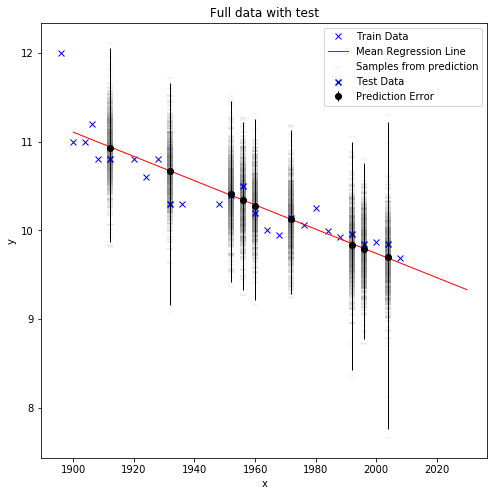

In [84]:
plt.figure(figsize=(8, 8))
plt.errorbar(X_test, mean, yerr=.95*errors, c='black', fmt='o', label='Prediction Error', lw=1)

label='Samples from prediction'
for x in ppc['y']:
    for n, i in enumerate(x):
        plt.scatter(X_test[n], i, marker='_', c="grey", label=label, alpha=0.1)
        label=None
plt.plot(X_train, y, 'x', label='Train Data', c='blue')
plt.scatter(X_test, y_test, marker='x', label='Test Data', c='blue')

plt.plot(bx, by, label="Mean Regression Line", lw=1., c="red")
plt.title('Full data with test')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()